# 1. Setting up the environment

## 1.1 Load Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.stattools import ccf
import statsmodels.formula.api as smf
from scipy import stats
import scipy.stats as stats
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from datetime import date
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import statsmodels as sm
import statsmodels.api as smt
import statsmodels.tsa.seasonal
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing

## 1.2 Load Data

In [2]:
train_data_raw = pd.read_csv("/Users/liujuntong/Desktop/QBUS3600/Individual Assignment/BigW_Data_2024_S1/FinSalesPriceData_train.csv")
test_data_raw = pd.read_csv("/Users/liujuntong/Desktop/QBUS3600/Individual Assignment/BigW_Data_2024_S1/FinSalesPriceData_test.csv")
competitor_data_raw = pd.read_csv("/Users/liujuntong/Desktop/QBUS3600/Individual Assignment/BigW_Data_2024_S1/CompetitorPriceData.csv")

In [3]:
train_data_raw.head()

,calendar_day,article_id,article_desc,category,subcategory,segment,brand,brandtype,sell_price,promo_price,promo_sales,promo_units,gross_profit,scanback,sales_amount,sales_units,cnt_site_art_ranged,cnt_site_art_ranged_pstv_soh,tot_soh_ranged_sites,gst_flag
0,2022-02-07,196544,Skin Control Pimple Patch Micro Dart 9pk,Skin & Sun Care,Skincare Face,Other,SKIN CONTROL,National Brand,13.00,13.0,13.0,1,86.550,0.0,190.7080,15,176,171,1444.0,Y
1,2022-02-07,103515,Spascriptions Superfoods Masks 3x 50ml,Skin & Sun Care,Skincare Face,Masks,SPASCRIPTIONS,National Brand,20.00,NaN,NaN,0,28.719,0.0,59.7999,3,176,175,1907.0,Y
2,2022-02-07,103517,Spascriptions Retinol Facial Serum,Skin & Sun Care,Skincare Face,Masks,SPASCRIPTIONS,National Brand,18.00,NaN,NaN,0,17.158,0.0,35.8198,2,176,174,844.0,Y
3,2022-02-07,103518,Spascriptions Collagen Facial Serum,Skin & Sun Care,Skincare Face,Masks,SPASCRIPTIONS,National Brand,18.00,NaN,NaN,0,42.926,0.0,89.6396,5,176,174,938.0,Y
4,2022-02-07,103520,7th Heaven Blackhead Stardust Face Mask,Skin & Sun Care,Skincare Face,7Th Heaven,7TH HEAVEN,National Brand,6.95,NaN,NaN,0,16.919,0.0,41.5209,6,176,173,1960.0,Y


## 1.3 Make a copy of the data

In [4]:
# make a copy of the data
data_train = train_data_raw.copy()
data_test = test_data_raw.copy()
data_c = competitor_data_raw.copy()

# 2. Data Preprocessing

## 2.1 Split the train data for train and validation sets

In [5]:
data_train_idx, data_val_idx = train_test_split(data_train.index, test_size=0.2, random_state=3600)
data_train = train_data_raw.loc[data_train_idx]
data_val = train_data_raw.loc[data_val_idx]

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)


(1000013, 20)
(250004, 20)
(605777, 20)


## 2.2 Missing Value Management

In [6]:
# function that process the selling price data
def missing_sell_price(data):
    # Calculate NA sell price using sales amount / sales units
    data['sell_price'] = data['sell_price'].fillna(data['sales_amount']/data['sales_units'])
    # Use previous sell price of no sales amount
    data['sell_price'] = data['sell_price'].fillna(method='ffill')
    return data

# function that process missing promo price and promo sales
def missing_promo(data):
    for idx in data.index:
        if pd.isna(data['promo_price'][idx]) and pd.notna(data['promo_sales'][idx]):
            data['promo_sales'][idx] = np.nan
    return data

In [7]:
data_train = missing_sell_price(data_train)
data_train = missing_promo(data_train)

data_val = missing_sell_price(data_val)
data_val = missing_promo(data_val)

data_test = missing_sell_price(data_test)
data_test = missing_promo(data_test)

In [8]:
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(1000013, 20)
(250004, 20)
(605777, 20)


## 2.3 Inconsistencies and Anomalies

### 2.3.1 Negative Sell Price, Promotion Price, Promotional Sales, and Scanback

In [9]:
# function that drop negative promotion negative, negative sell price
def drop_neg_invalid_rows(data):
    data = data.drop(data[data['promo_price'] < 0].index)
    data = data.drop(data[data['promo_sales'] < 0].index)
    data = data.drop(data[data['scanback'] < 0].index)
    data = data.drop(data[data['sell_price'] < 0].index)
    return data

data_train = drop_neg_invalid_rows(data_train)
data_val = drop_neg_invalid_rows(data_val)
data_test = drop_neg_invalid_rows(data_test)

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(997831, 20)
(249465, 20)
(604344, 20)


### 2.3.2 Availability Issues

In [10]:
# function that drop rows with availability issues
def rm_availability_issue(data):
    condition = data[(data['cnt_site_art_ranged'] > 0) & (data['tot_soh_ranged_sites'] == 0)]
    data = data.drop(condition.index)
    return data

data_train = rm_availability_issue(data_train)
data_val = rm_availability_issue(data_val)
data_test = rm_availability_issue(data_test)

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(972425, 20)
(243254, 20)
(596838, 20)


### 2.3.3 Invalid Sales (Sales Units and Promotional Units)

In [11]:
# function that drop rows where promo units or sales units are more than stock
def drop_sell_more_than_stock(data):
    data = data.drop(data[data['sales_units'] > data['tot_soh_ranged_sites']].index)
    data = data.drop(data[data['promo_units'] > data['tot_soh_ranged_sites']].index)
    return data

data_train = drop_sell_more_than_stock(data_train)
data_val = drop_sell_more_than_stock(data_val)
data_test = drop_sell_more_than_stock(data_test)

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(919962, 20)
(230080, 20)
(562224, 20)


### 2.3.4 Duplicates

In [12]:
# function that remove duplicates
def remove_duplicates(data):
    duplicate = data.duplicated()
    data = data.drop(data[duplicate].index)
    return data

data_train = remove_duplicates(data_train)
data_val = remove_duplicates(data_val)
data_test = remove_duplicates(data_test)

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(919962, 20)
(230080, 20)
(562224, 20)


### 2.3.5 Promo Price higher and equal to Sell Price

In [13]:
def remove_invalid_promo(data):
    data = data.drop(data[(data['promo_price'] >= data['sell_price'])].index)
    return data

data_train = remove_invalid_promo(data_train)
data_val = remove_invalid_promo(data_val)
data_test = remove_invalid_promo(data_test)

print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(919146, 20)
(229874, 20)
(561534, 20)


### 2.3.5 Drop Inventory Features
- This is because we won't know for certain what the inventory levels will be in the future.

In [14]:
data_train = data_train.drop(['cnt_site_art_ranged', 'cnt_site_art_ranged_pstv_soh', 'tot_soh_ranged_sites'], axis=1)
data_val = data_val.drop(['cnt_site_art_ranged', 'cnt_site_art_ranged_pstv_soh', 'tot_soh_ranged_sites'], axis=1)
data_test = data_test.drop(['cnt_site_art_ranged', 'cnt_site_art_ranged_pstv_soh', 'tot_soh_ranged_sites'], axis=1)

### 2.4 Data Types Transformation
1. Convert `calendar_day` to datetime
2. Create dummy variables for categorical features
    - `article_desc` does not have a clear categorisation, so we will not create dummy for it

In [15]:
def cat_to_dum(data, var_name):
    category_dummies = pd.get_dummies(data[var_name], prefix=var_name)
    data = pd.concat([data, category_dummies], axis=1)
    data = data.drop(var_name, axis=1)
    return data
    
def data_type_transform(data):
    # find the categorical columns
    cat_columns = data.select_dtypes(include=['object']).columns
    
    # transform calendar_day to datetime object
    data['calendar_day'] = pd.to_datetime(data['calendar_day'])
    
    # transform category to dummy
    data = cat_to_dum(data, 'category')
    
    # transform sub_category to dummy
    data = cat_to_dum(data, 'subcategory')
    
    # transform segment to dummy
    data = cat_to_dum(data, 'segment')
    
    # transform brand to dummy
    data = cat_to_dum(data, 'brand')
    
    # transform brandtype to dummy
    data = cat_to_dum(data, 'brandtype')
    
    # transform gst to dummy
    data = cat_to_dum(data, 'gst_flag')

    return data

In [16]:
data_train_with_dummy = data_train.copy()
data_train_with_dummy = data_type_transform(data_train_with_dummy)

data_val_with_dummy = data_val.copy()
data_test_with_dummy = data_test.copy()

data_val_with_dummy = data_type_transform(data_val_with_dummy)
data_test_with_dummy = data_type_transform(data_test_with_dummy)

In [17]:
print(data_train_with_dummy.shape)
print(data_val_with_dummy.shape)
print(data_test_with_dummy.shape)

(919146, 413)
(229874, 413)
(561534, 413)


## 2.5 Additional Variables
1. Revised profits:
    `net_proft` = `gross_profit` + `scanback`

2. Cost of purchasing:
    2.1 if GST is present: `sales_amount_exclude_gst` = `sales_amount` / 1.1
    2.2 if GST is absent: `sales_amount_exclude_gst` = `sales_amount`
    `cost_of_purchasing` = `sales_amount_exclude_gst` - `net_profit`

3. Sales units per dollar decrease to see the price elasticity of the article:
    `sales_units_per_dollar` = `promo_units` / (`selling_price` - `promo_price`)

4. Day of Week
    `day_of_week` = `date`.dt.dayofweek

5. Whether competitor has a lower selling or shelves price

6. Whether the article is on promotion (0 for no, 1 for yes)


In [18]:
def new_var(data):
    # Calculate revised net profit
    data['net_profit'] = data['gross_profit'] + data['scanback']
    
    # Calculate sales amount excluding GST using vectorized operation
    data['sales_amount_exclude_gst'] = data['sales_amount'] / (1.1 if 'gst_flag_Y' in data.columns and data['gst_flag_Y'].all() else 1)
    
    # Calculate cost of purchasing
    data['cost_of_purchasing'] = data['sales_amount_exclude_gst'] - data['net_profit']
    
    # Calculate sales units per dollar decrease due to promotions
    data['marginal_sales_per_dollar_decrease'] = data['promo_units'] / (data['sell_price'] - data['promo_price'])
    
    # Extract day of week from 'calendar_day'
    data['day_of_week'] = data['calendar_day'].dt.dayofweek
    ## treat day_of_week as categorical
    data = cat_to_dum(data, 'day_of_week')
    
    # Identify whether the article is on promotion
    data['on_promo'] = data['promo_price'].apply(lambda x: 1 if x > 0 else 0)
    ## change on_promo to bool
    data['on_promo'] = data['on_promo'].astype(bool)
    
    return data

data_train_with_dummy = new_var(data_train_with_dummy)
data_val_with_dummy = new_var(data_val_with_dummy)
data_test_with_dummy = new_var(data_test_with_dummy)

In [19]:
print(data_train_with_dummy.shape)
print(data_val_with_dummy.shape)
print(data_test_with_dummy.shape)

(919146, 425)
(229874, 425)
(561534, 425)


## 2.6 Standardisation

### 2.6.1 Split into normal and promotional data

In [20]:
def normal_promo_sets(data):
    return data[data["promo_price"].isna()], data[data["promo_price"].notna()]

# Split data into Normal Sales and Promo Sales
train_normal, train_promo = normal_promo_sets(data_train_with_dummy)
test_normal, test_promo = normal_promo_sets(data_test_with_dummy)
val_normal, val_promo = normal_promo_sets(data_val_with_dummy)

# check shape
print(train_normal.shape)
print(train_promo.shape)
print(test_normal.shape)
print(test_promo.shape)
print(val_normal.shape)
print(val_promo.shape)

(733589, 425)
(185557, 425)
(441888, 425)
(119646, 425)
(183182, 425)
(46692, 425)


### 2.6.2 Standardise the data

In [21]:
# check numerical columns
train_normal.select_dtypes(include=['int', 'float']).columns

# colns that have na values for normal sales
print(train_normal.columns[train_normal.isna().any()])

# colns that have na values for promo sales
print(train_promo.columns[train_promo.isna().any()])
print(train_promo.columns[train_promo.isin([np.nan, np.inf, -np.inf]).any()])
print(train_promo['marginal_sales_per_dollar_decrease'].value_counts())

Index(['promo_price', 'promo_sales', 'marginal_sales_per_dollar_decrease'], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
marginal_sales_per_dollar_decrease
2.000000      573
4.000000      503
1.000000      483
0.666667      421
1.333333      396
             ... 
56.787330       1
22.096317       1
20.487805       1
0.804598        1
489.189189      1
Name: count, Length: 57978, dtype: int64


In [22]:
def prepare_for_std(data, promo=False):
    # rm the columns that are misclassified as numerical
    data['article_id'] = data_train_with_dummy['article_id'].astype(str)
    
    # consider two cases: normal sales and promo sales
    ## for normal sales drop promo columns
    if promo == False:
        data = data.drop(['promo_price', 'promo_sales', 'marginal_sales_per_dollar_decrease'], axis=1)
    return data

train_normal = prepare_for_std(train_normal)
train_promo = prepare_for_std(train_promo, promo=True)
val_normal = prepare_for_std(val_normal)
val_promo = prepare_for_std(val_promo, promo=True)
test_normal = prepare_for_std(test_normal)
test_promo = prepare_for_std(test_promo, promo=True)

# check shape
print(train_normal.shape)
print(train_promo.shape)
print(val_normal.shape)
print(val_promo.shape)
print(test_normal.shape)
print(test_promo.shape)

(733589, 422)
(185557, 425)
(183182, 422)
(46692, 425)
(441888, 422)
(119646, 425)


In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(train_normal[['sales_units']])

train_normal['sales_units'] = scaler.transform(train_normal[['sales_units']])
val_normal['sales_units'] = scaler.transform(val_normal[['sales_units']])
test_normal['sales_units'] = scaler.transform(test_normal[['sales_units']])

In [24]:
scaler.fit(train_promo[['sales_units']])

train_promo['sales_units'] = scaler.transform(train_promo[['sales_units']])
val_promo['sales_units'] = scaler.transform(val_promo[['sales_units']])
test_promo['sales_units'] = scaler.transform(test_promo[['sales_units']])

### 2.7 Split data into x features and y target

In [25]:
def y_x_split(data):
    return data["sales_units"], data.drop("sales_units", axis =1)

# Split data into x and y sets
y_train_normal, x_train_normal = y_x_split(train_normal)
y_train_promo, x_train_promo = y_x_split(train_promo)

y_test_normal, x_test_normal = y_x_split(test_normal)
y_test_promo, x_test_promo = y_x_split(test_promo)

y_val_normal, x_val_normal = y_x_split(val_normal)
y_val_promo, x_val_promo = y_x_split(val_promo)

# check shape
print(y_train_normal.shape)
print(x_train_normal.shape)
print(y_train_promo.shape)
print(x_train_promo.shape)

print(y_test_normal.shape)
print(x_test_normal.shape)
print(y_test_promo.shape)
print(x_test_promo.shape)

print(y_val_normal.shape)
print(x_val_normal.shape)
print(y_val_promo.shape)
print(x_val_promo.shape)

(733589,)
(733589, 421)
(185557,)
(185557, 424)
(441888,)
(441888, 421)
(119646,)
(119646, 424)
(183182,)
(183182, 421)
(46692,)
(46692, 424)


### 2.8 Merge x_normal and y_normal, x_promo and y_promo

In [26]:
train_normal = pd.concat([x_train_normal, y_train_normal], axis=1)
val_normal = pd.concat([x_val_normal, y_val_normal], axis=1)
test_normal = pd.concat([x_test_normal, y_test_normal], axis=1)

In [27]:
train_promo = pd.concat([x_train_promo, y_train_promo], axis=1)
val_promo = pd.concat([x_val_promo, y_val_promo], axis=1)
test_promo = pd.concat([x_test_promo, y_test_promo], axis=1)

## 3. Time Series (normal period)
### 3.1 Time Series EDA: data preprocessing

In order to explore how sales_units effected by time, we create a new dataset with `calendar_day` and `sales_units` on train set and test set seperately.

In [28]:
# Select time series variables 
train_normal = train_normal[['calendar_day','sales_units']].copy()
# Convert the index of train_normal to DatetimeIndex
train_normal.index = pd.to_datetime(train_normal.index)
# Convert DatetimeIndex into PeriodIndex
train_normal.index = train_normal.index.to_period(freq='D')
# Reset index
train_normal.set_index('calendar_day', inplace=True)
# rearranging y_train by calendar_day
train_normal = train_normal.sort_values(by='calendar_day', ascending=True)
train_normal = train_normal

In [29]:
# Select time series variables 
val_normal = val_normal[['calendar_day','sales_units']].copy()
# Convert the index of train_normal to DatetimeIndex
val_normal.index = pd.to_datetime(val_normal.index)
# Convert DatetimeIndex into PeriodIndex
val_normal.index = val_normal.index.to_period(freq='D')
# Reset index
val_normal.set_index('calendar_day', inplace=True)
# rearranging y_train by calendar_day
val_normal = val_normal.sort_values(by='calendar_day', ascending=True)
val_normal = val_normal

In [30]:
train_normal

,sales_units
calendar_day,
2022-02-07,-0.280152
2022-02-07,-0.365220
2022-02-07,0.009079
2022-02-07,-0.365220
2022-02-07,0.077133
...,...
2023-05-26,-0.297166
2023-05-26,-0.365220
2023-05-26,-0.365220


In [31]:
# Select time series variables 
# Test set seperate
test_normal = test_normal[['calendar_day','sales_units']].copy()
test_normal.index = pd.to_datetime(test_normal.index)
test_normal.index = test_normal.index.to_period(freq='D')
test_normal.set_index('calendar_day', inplace=True)
test_normal = test_normal.sort_values(by='calendar_day', ascending=True)
test_normal = test_normal

Merge train, vali, test

In [32]:
normal = pd.concat([train_normal, val_normal, test_normal], ignore_index=True)

Define length of the set (for multiple step forecast)

In [33]:
T_train = len(train_normal)
T_test = len(test_normal)
T_val = len(val_normal)

Define `sales_units` in `normal` (for multi step forecast)

- `normal_sales_units` is the value form of `normal['sales_units']`column.

In [34]:
normal_sales_units = normal['sales_units']

#### 3.2 Data visualisation

Line chart

In [35]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

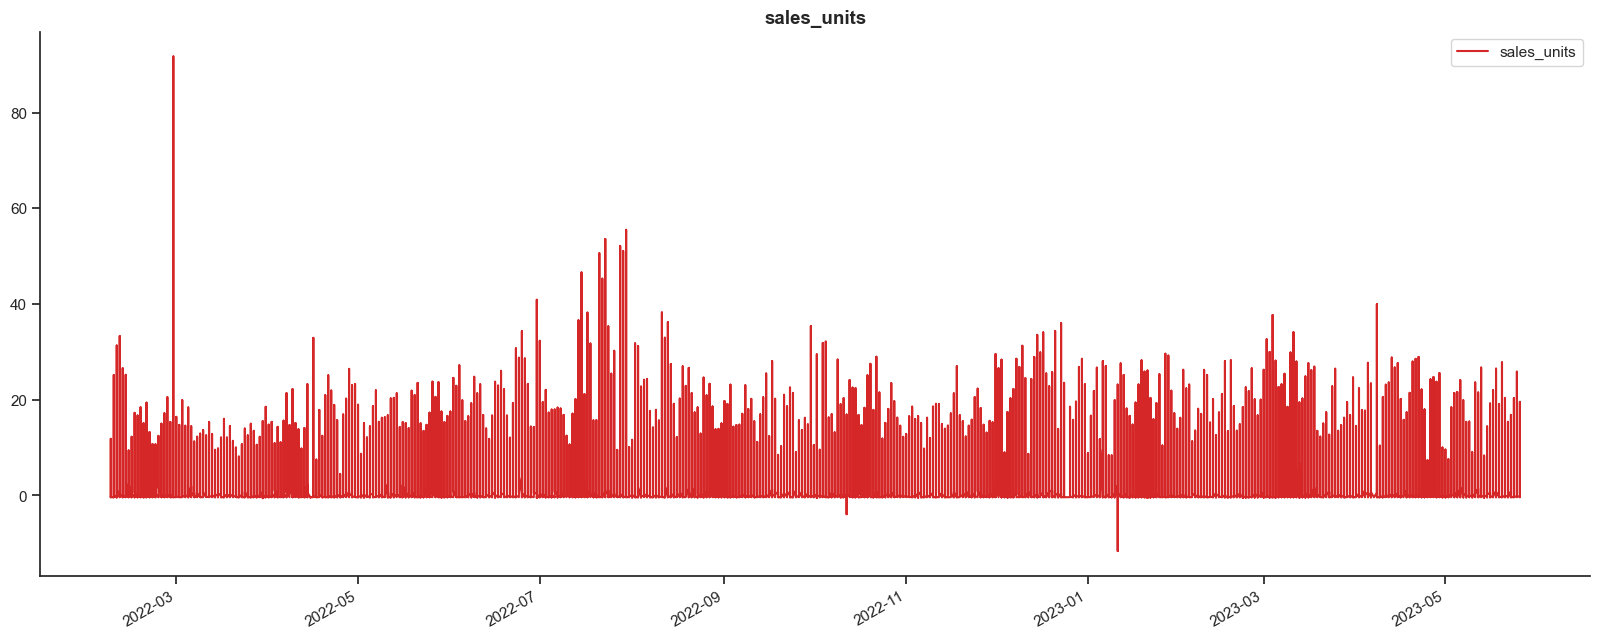

In [36]:
fig, ax = plt.subplots(figsize=(20, 8))
train_normal.plot(color='#D62728', label='sales_units', ax=ax)  
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title('sales_units', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

Decomposition plot

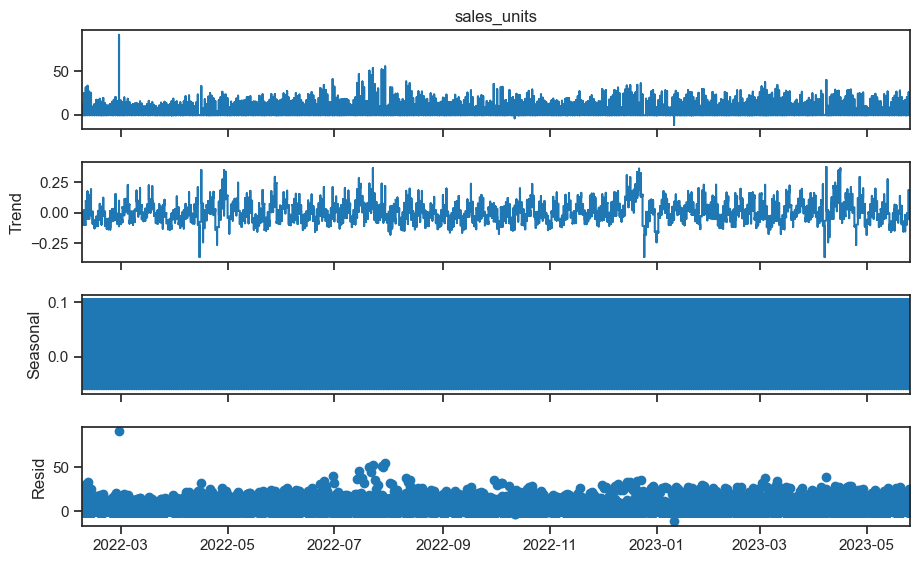

In [37]:
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(train_normal['sales_units'], period=480)

decomposition.plot()

plt.gcf().set_size_inches(10, 6)  

plt.show()

### 3.3 Accuracy measures: RMSE


In [38]:
def MSE(y,y_hat):
    mse = np.mean((y - y_hat) ** 2)
    return(mse)

In [39]:
def RMSE(y,y_hat):
    mse = np.mean((y - y_hat) ** 2)
    rmse = np.sqrt(mse)
    return(rmse)

### 3.4 Random Walk

For RW model, we only do **forecasting**:

- The reason is when it comes to random walks, it's typically assumed that future states are determined by random fluctuations from the current state rather than influenced by other factors. 
- Therefore, random walks are better suited for predicting future outcomes rather than fitting to data.

Point forecast:

- h-step point forecast, where h = the length of the test set.

In [40]:
np.random.seed(3600)

randomwalk = pd.Series(np.zeros(T_test))

randomwalk.index = test_normal.index

for i in np.arange(T_test):
    randomwalk[i] = normal_sales_units[T_train - 1]

forecast = pd.DataFrame(test_normal.copy())
forecast["Benchmark Model"] = randomwalk
forecast

,sales_units,Benchmark Model
calendar_day,,
2023-05-26,-0.263138,0.247269
2023-05-26,-0.229111,0.247269
2023-05-26,-0.365220,0.247269
2023-05-26,-0.365220,0.247269
2023-05-26,0.281296,0.247269
...,...,...
2024-01-11,-0.365220,0.247269
2024-01-11,-0.365220,0.247269
2024-01-11,-0.041962,0.247269


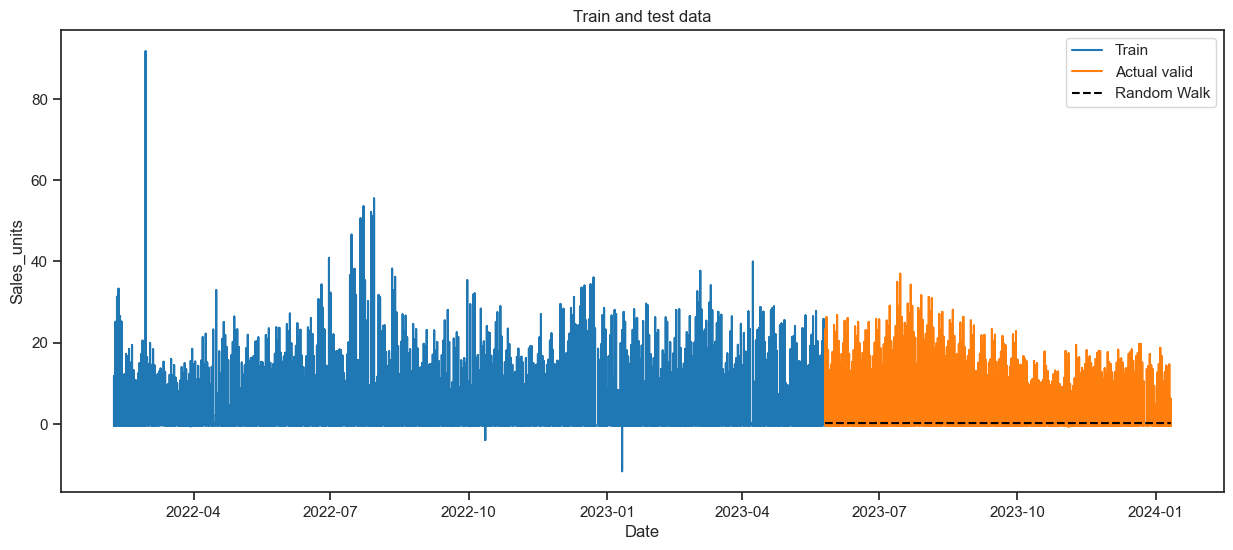

In [41]:
plt.figure(figsize = (15,6))

plt.plot(train_normal, label = "Train")
plt.plot(test_normal, label = "Actual valid" )
plt.plot(randomwalk, "--", color = "black", label = "Random Walk")

plt.xlabel("Date")
plt.ylabel("Sales_units")
plt.title("Train and test data")

plt.legend()

plt.show()

In [42]:
# standarised rmse
print("MSE (Random Walk) : {:.4f}".format(MSE(test_normal['sales_units'],randomwalk)))
print("RMSE (Random Walk) : {:.4f}".format(RMSE(test_normal['sales_units'],randomwalk)))

MSE (Random Walk) : 0.8761
RMSE (Random Walk) : 0.9360


In [43]:
# un-standarise RMSE process
inversed_test_normal = scaler.inverse_transform(test_normal[['sales_units']])

In [44]:
inversed_randomwalk = scaler.inverse_transform(forecast)

In [45]:
print("MSE (Random Walk) : {:.4f}".format(MSE(inversed_test_normal,inversed_randomwalk)))
print("RMSE (Random Walk) : {:.4f}".format(RMSE(inversed_test_normal,inversed_randomwalk)))

MSE (Random Walk) : 2619.8178
RMSE (Random Walk) : 51.1842


### 3.5 Seasonal Naive Forecasting

In [46]:
np.random.seed(3600)

M = 7

Seasonal_Naive = pd.Series(np.zeros(T_test))
Seasonal_Naive.index = test_normal.index

for i in np.arange(T_test):
    Seasonal_Naive[i] = normal_sales_units[T_train + i - M]

forecast["Seasonal Naive"] = Seasonal_Naive

forecast

,sales_units,Benchmark Model,Seasonal Naive
calendar_day,,,
2023-05-26,-0.263138,0.247269,-0.365220
2023-05-26,-0.229111,0.247269,-0.365220
2023-05-26,-0.365220,0.247269,-0.297166
2023-05-26,-0.365220,0.247269,-0.365220
2023-05-26,0.281296,0.247269,-0.365220
...,...,...,...
2024-01-11,-0.365220,0.247269,-0.365220
2024-01-11,-0.365220,0.247269,-0.058975
2024-01-11,-0.041962,0.247269,0.519486


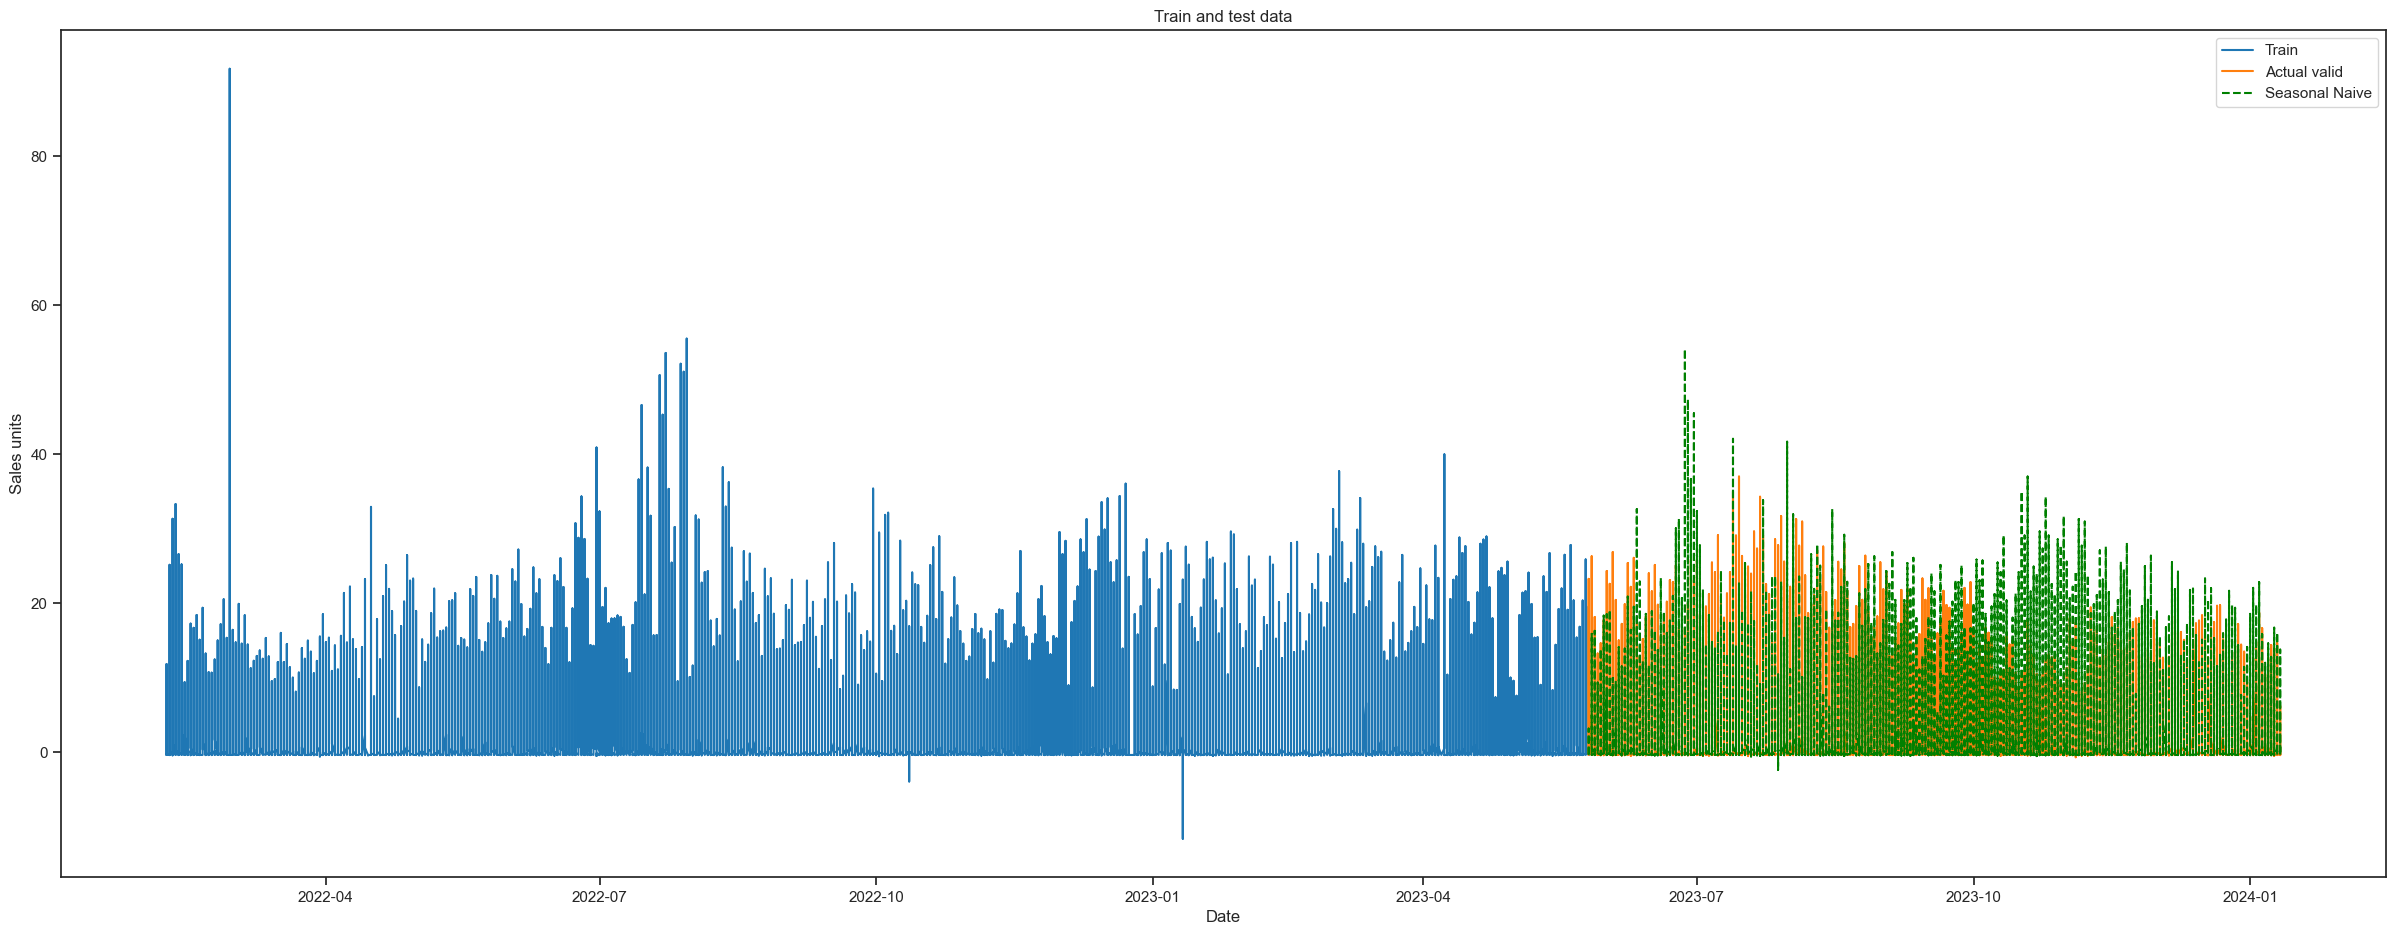

In [47]:
plt.figure(figsize = (30,11))

plt.plot(train_normal, label = "Train")
plt.plot(test_normal, label = "Actual valid")
plt.plot(Seasonal_Naive, "--", color = "green", label = "Seasonal Naive")


plt.title("Train and test data")
plt.xlabel("Date")
plt.ylabel("Sales units")
plt.legend()

plt.show()

In [48]:
# standarise rmse
print("MSE (Seasonal naive) : {:.4f}".format(MSE(test_normal['sales_units'],Seasonal_Naive)))
print("RMSE (Seasonal naive) : {:.4f}".format(RMSE(test_normal['sales_units'],Seasonal_Naive)))

MSE (Seasonal naive) : 1.7264
RMSE (Seasonal naive) : 1.3139


In [49]:
# Un-standarise 
inversed_seasonal = scaler.inverse_transform(forecast)

In [50]:
print("MSE (Seasonal naive) : {:.4f}".format(MSE(inversed_test_normal,inversed_seasonal)))
print("RMSE (Seasonal naive) : {:.4f}".format(RMSE(inversed_test_normal,inversed_seasonal)))

MSE (Seasonal naive) : 5188.2974
RMSE (Seasonal naive) : 72.0298


### 3.6 Simple exponential smoothing (SES)

Based on EDA decomposition plot we find that normal sales has no clear trends, thus we will try on simple exponential smoothing (SES). Alpha is the optimal situation of the model, indicates the most recent observation weight is optimal at 0.0050000 approximately.

In [51]:
test_sales = test_normal['sales_units'] 

ses_model = SimpleExpSmoothing(test_sales)
fitted_model = ses_model.fit()

fitted_values = pd.Series(fitted_model.fittedvalues, index=test_sales.index)

fitted_model.summary()

Dep. Variable:,sales_units,No. Observations:,441888
Model:,SimpleExpSmoothing,SSE,338043.143
Optimized:,True,AIC,-118370.250
Trend:,None,BIC,-118348.253
Seasonal:,None,AICC,-118370.250
Seasonal Periods:,None,Date:,"Mon, 13 May 2024"
Box-Cox:,False,Time:,21:43:09
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0949877,alpha,True
initial_level,-0.2631384,l.0,False


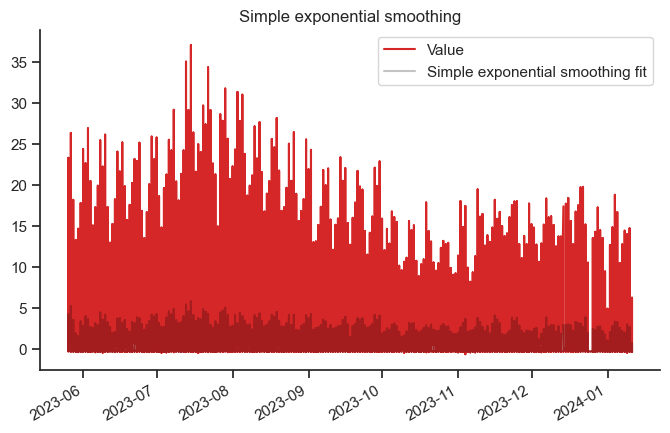

In [52]:
fig, ax= plt.subplots(figsize=(8,5))
test_sales.plot(color=red, label='Value')
fitted_values.plot(color='black', label='Simple exponential smoothing fit', alpha=0.237)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Simple exponential smoothing')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

In [53]:
# standarised rmse
print("MSE (SES) : {:.4f}".format(MSE(train_normal['sales_units'],fitted_values)))
print("RMSE (SES) : {:.4f}".format(RMSE(train_normal['sales_units'],fitted_values)))

MSE (SES) : 1.6241
RMSE (SES) : 1.2744


In [54]:
# Un-standarise 
fitted_values = pd.DataFrame(fitted_model.fittedvalues, index=test_sales.index)

# de-standarized fitted value
inversed_ses = scaler.inverse_transform(fitted_values)

# convert de-standarized result into series for visualisation
inversed_ses = pd.Series(inversed_ses.flatten(), index=test_sales.index)

In [55]:
print("MSE (SES) : {:.4f}".format(MSE(test_normal['sales_units'],inversed_ses)))
print("RMSE (SES) : {:.4f}".format(RMSE(test_normal['sales_units'],inversed_ses)))

MSE (SES) : 3863.1500
RMSE (SES) : 62.1542


### 3.7 Moving Average 
#### MA7

In [56]:
np.random.seed(3600)

ma7_prediction = train_normal.rolling(7).mean()

MA7 = pd.Series(np.zeros(T_test))

MA7.index = test_normal.index

for i in np.arange(T_test):
    MA7[i] = normal_sales_units[T_train - 1]

forecast["Moving Average Model"] = MA7
forecast

,sales_units,Benchmark Model,Seasonal Naive,Moving Average Model
calendar_day,,,,
2023-05-26,-0.263138,0.247269,-0.365220,0.247269
2023-05-26,-0.229111,0.247269,-0.365220,0.247269
2023-05-26,-0.365220,0.247269,-0.297166,0.247269
2023-05-26,-0.365220,0.247269,-0.365220,0.247269
2023-05-26,0.281296,0.247269,-0.365220,0.247269
...,...,...,...,...
2024-01-11,-0.365220,0.247269,-0.365220,0.247269
2024-01-11,-0.365220,0.247269,-0.058975,0.247269
2024-01-11,-0.041962,0.247269,0.519486,0.247269


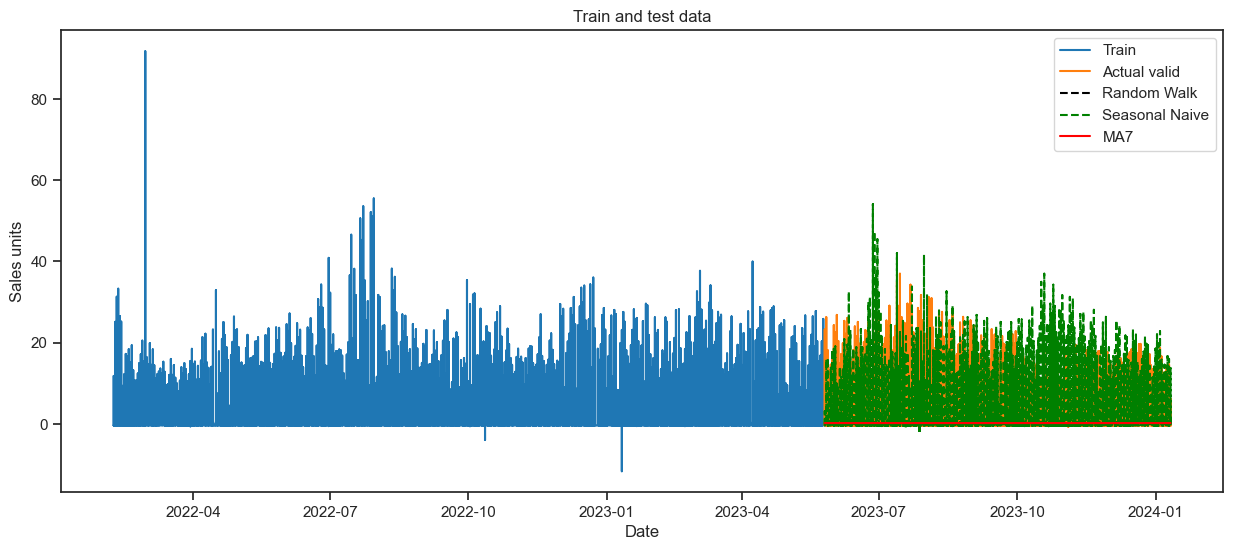

In [57]:
plt.figure(figsize = (15,6))

plt.plot(train_normal, label = "Train")

plt.plot(test_normal, label = "Actual valid")

plt.plot(randomwalk, "--", color = "black", label = "Random Walk")

plt.plot(Seasonal_Naive, "--", color = "green", label = "Seasonal Naive")
plt.plot(MA7, "-", color = "red", label = "MA7")

plt.title("Train and test data")
plt.xlabel("Date")
plt.ylabel("Sales units")
plt.legend()

plt.show()

In [58]:
#standarised rmse
print("MSE (MA) : {:.4f}".format(MSE(test_normal['sales_units'],MA7)))
print("RMSE (MA) : {:.4f}".format(RMSE(test_normal['sales_units'],MA7)))

MSE (MA) : 0.8761
RMSE (MA) : 0.9360


In [59]:
# Un-standarise rmse
inversed_MA = scaler.inverse_transform(forecast)

In [60]:
print("MSE (MA) : {:.4f}".format(MSE(inversed_test_normal,inversed_MA)))
print("RMSE (MA) : {:.4f}".format(RMSE(inversed_test_normal,inversed_MA)))

MSE (MA) : 5201.1319
RMSE (MA) : 72.1189


### 3.8 ARIMA (Auto Regressive Integrated Moving Average)

The prerequisite for using ARIMA model is **Stationarity**.

- Stationary means `sales_units` time series model will not change over time (constant mean, constant variance, constant covariance)
- From decomposition plot in section 4.2, we find that the residual of BigW data seems not distributed evenly.
- First difference could remove trend, seasonality etc to ensure mean doesn't change over time, which ensure stationarity holds.

#### 3.8.1 First Difference:

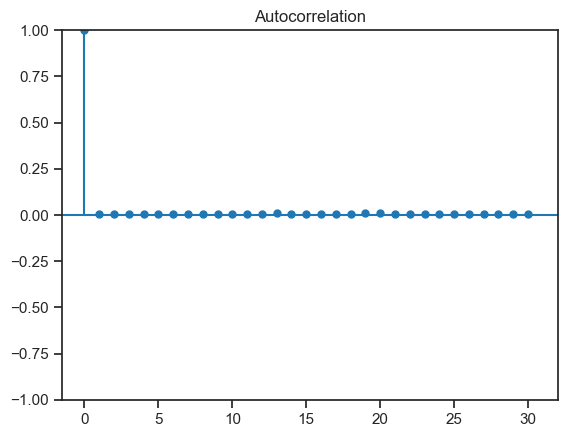

In [61]:
smt.graphics.tsa.plot_acf(train_normal, lags=30, alpha = 0.05)
plt.show()

In [62]:
s_diff = pd.Series.diff(train_normal).dropna()
s_diff

,0
calendar_day,
2022-02-07,-0.085068
2022-02-07,0.374299
2022-02-07,-0.374299
2022-02-07,0.442353
2022-02-07,-0.187149
...,...
2023-05-26,0.068054
2023-05-26,-0.068054
2023-05-26,0.000000


By taking the 1st difference, the time series is centered around 0, suggests stationary holds.

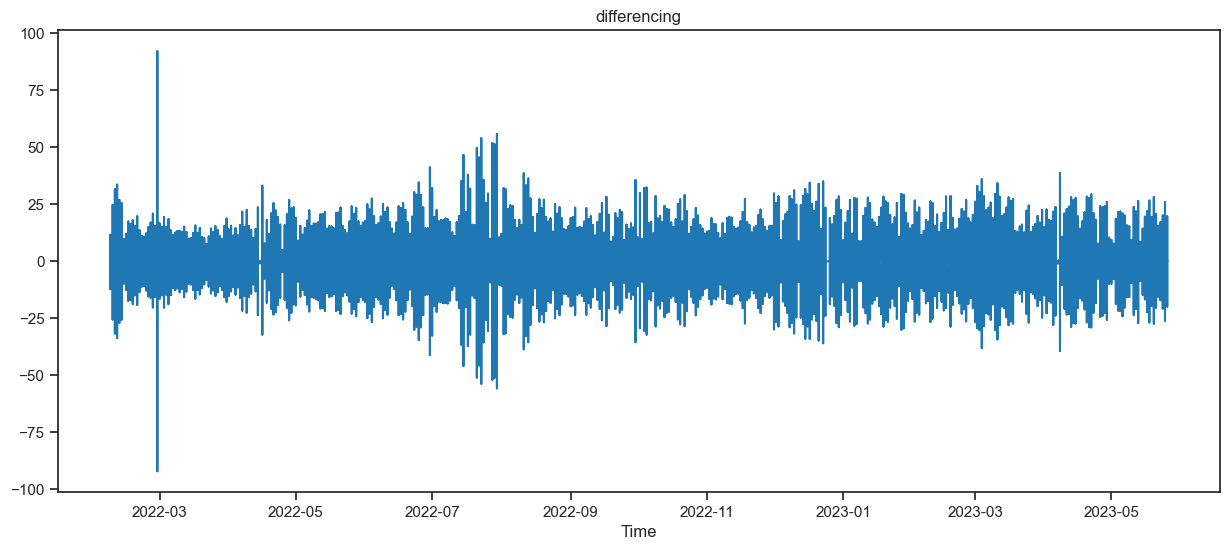

In [63]:
plt.figure(figsize=(15,6))
plt.plot(s_diff)
plt.xlabel("Time")
plt.title("differencing")
plt.show()

#### 3.8.2 ACF and PACF visualisation after first difference

- After doing 1st difference, the first two lags of ACF plot is very big, and the other lags are close to 0, ACF cuts off from lag 2;

- PACF dies down from lag 2;

- ACF cuts off, PACF dies down -> pattern of MA model -> which we've done above

- However, though we set 95% confidence band, it does not shows clearly from the ACF plot. Thus we could not know the lag of ARIMA directly from ACF and PACF plot.

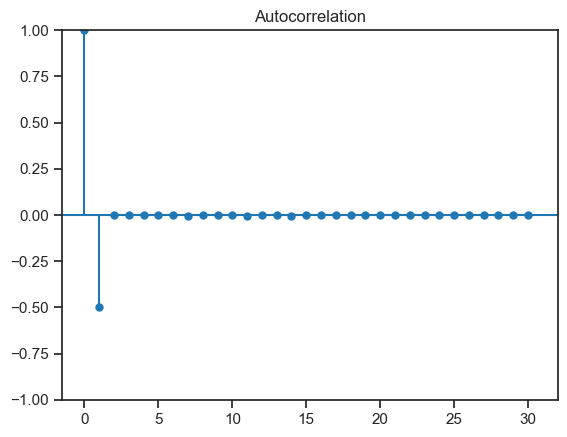

In [64]:
smt.graphics.tsa.plot_acf(s_diff, lags=30, alpha = 0.05)
plt.show()

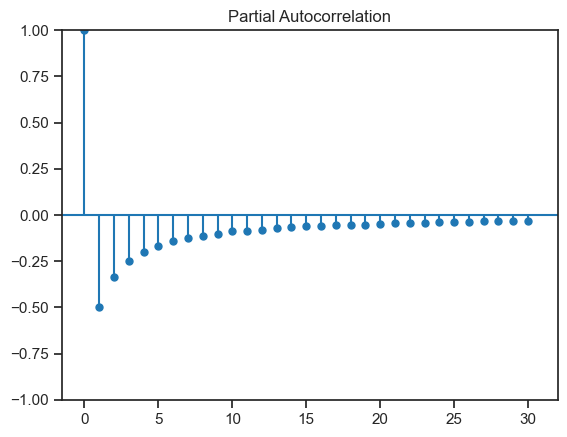

In [65]:
smt.graphics.tsa.plot_pacf(s_diff, lags=30, alpha = 0.05)
plt.show()

In [66]:
ARIMA1 = train_normal
model_arima = ARIMA(ARIMA1, order = (3,1,2)).fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:            sales_units   No. Observations:               733589
Model:                 ARIMA(3, 1, 2)   Log Likelihood            -1039644.778
Date:                Mon, 13 May 2024   AIC                        2079301.556
Time:                        21:48:18   BIC                        2079370.590
Sample:                             0   HQIC                       2079320.793
                             - 733589                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9317      0.271     -3.433      0.001      -1.464      -0.400
ar.L2         -0.0008      0.002     -0.445      0.656      -0.004       0.003
ar.L3         -0.0010      0.001     -0.826      0.4

In [67]:
forecast_arima = pd.DataFrame(model_arima.forecast(441888))
forecast_arima.set_index(test_normal.index, inplace = True)
forecast_arima

,predicted_mean
calendar_day,
2023-05-26,0.008382
2023-05-26,0.008107
2023-05-26,0.008121
2023-05-26,0.008357
2023-05-26,0.008138
...,...
2024-01-11,0.008243
2024-01-11,0.008243
2024-01-11,0.008243


In [68]:
forecast = pd.DataFrame(test_normal.copy())
forecast["ARIMA"] = forecast_arima
forecast

,sales_units,ARIMA
calendar_day,,
2023-05-26,-0.263138,0.008382
2023-05-26,-0.229111,0.008107
2023-05-26,-0.365220,0.008121
2023-05-26,-0.365220,0.008357
2023-05-26,0.281296,0.008138
...,...,...
2024-01-11,-0.365220,0.008243
2024-01-11,-0.365220,0.008243
2024-01-11,-0.041962,0.008243


In [69]:
# Un-standarise 
inversed_arima = scaler.inverse_transform(forecast)

In [70]:
print("MSE (ARIMA) : {:.4f}".format(MSE(inversed_test_normal,inversed_arima)))
print("RMSE (ARIMA) : {:.4f}".format(RMSE(inversed_test_normal,inversed_arima)))

MSE (ARIMA) : 2397.0991
RMSE (ARIMA) : 48.9602


#### 3.9 Summary Table (normal sales_units)
| Model | Test set RMSE (Un-standarised) | Test set RMSE (standarised)
|-----|-----|-----|
| Random Walk | 51.1842 | 0.9360|
| Seasonal Random Walk | 72.0298 |1.3139|
| Simple exponential smoothing| 98.1429 |1.2744|
| Moving Average Model | 72.1189 |0.9360|

## 4 Time Series (promo period)

- All the model we do again on promo sales data.

- Random Walk, Seasonal Random Walk, Simple exponential smoothing, moving average.

- ACF cuts off, PACF dies down: conforms to Moving Average Model.



### 4.1 Promo Data preprocessing

In [71]:
# Select time series variables 
train_promo = train_promo[['calendar_day','sales_units']].copy()
# Convert the index of train_normal to DatetimeIndex
train_promo.index = pd.to_datetime(train_promo.index)
# Convert DatetimeIndex into PeriodIndex
train_promo.index = train_promo.index.to_period(freq='D')
# Reset index
train_promo.set_index('calendar_day', inplace=True)
# rearranging y_train by calendar_day
train_promo = train_promo.sort_values(by='calendar_day', ascending=True)
train_promo = train_promo

In [72]:
train_promo

,sales_units
calendar_day,
2022-02-07,-0.671802
2022-02-07,-0.374397
2022-02-07,-0.607149
2022-02-07,0.272136
2022-02-07,1.836746
...,...
2023-05-26,-0.348535
2023-05-26,-0.283882
2023-05-26,-0.335605


In [73]:
# seperate validation set for promotion 
val_promo = val_promo[['calendar_day','sales_units']].copy()
val_promo.index = pd.to_datetime(val_promo.index)
val_promo.index = val_promo.index.to_period(freq='D')
val_promo.set_index('calendar_day', inplace=True)
val_promo = val_promo.sort_values(by='calendar_day', ascending=True)
val_promo = val_promo

In [74]:
# seperate promotion test set 
test_promo = test_promo[['calendar_day','sales_units']].copy()
test_promo.index = pd.to_datetime(test_promo.index)
test_promo.index = test_promo.index.to_period(freq='D')
test_promo.set_index('calendar_day', inplace=True)
test_promo = test_promo.sort_values(by='calendar_day', ascending=True)
test_promo = test_promo

Merge train, vali, test

In [75]:
promo = pd.concat([train_promo, val_promo, test_promo], ignore_index=True)

Define length of the set (for multiple step forecast)

In [76]:
T_train_promo = len(train_promo)
T_test_promo = len(test_promo)
T_val_promo = len(val_promo)

Define `sales_units` in `promo` (for multiple step forecast)

In [77]:
promo_sales_units = promo['sales_units']

#### 4.2 Data visualisation

line chart

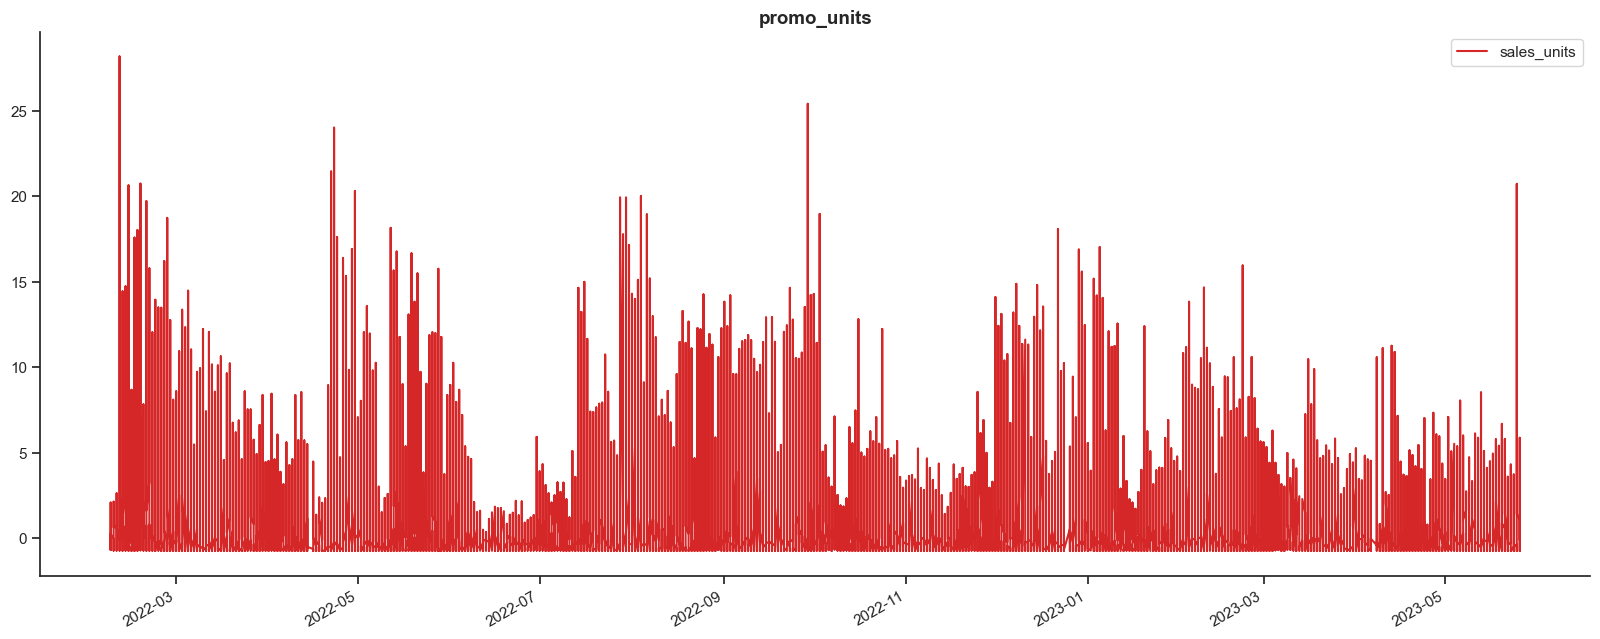

In [78]:
fig, ax = plt.subplots(figsize=(20, 8))
train_promo.plot(color='#D62728', label='promo_units', ax=ax)  
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title('promo_units', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

Decomposition plot

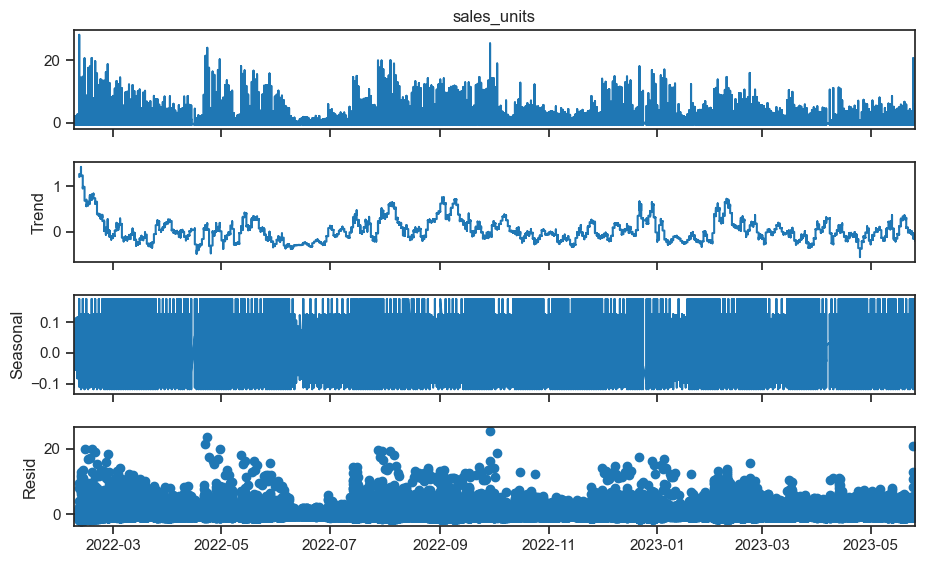

In [79]:
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(train_promo['sales_units'], period=480)

decomposition.plot()

plt.gcf().set_size_inches(10, 6)  

plt.show()

### 4.3 Random Walk

In [80]:
np.random.seed(3600)

randomwalk = pd.Series(np.zeros(T_test_promo))

randomwalk.index = test_promo.index

for i in np.arange(T_test_promo):
    randomwalk[i] = promo_sales_units[T_train_promo - 1]

forecast = pd.DataFrame(test_promo.copy())
forecast["Benchmark Model"] = randomwalk
forecast

,sales_units,Benchmark Model
calendar_day,,
2023-05-26,-0.620079,-0.102853
2023-05-26,-0.322674,-0.102853
2023-05-26,-0.283882,-0.102853
2023-05-26,-0.594218,-0.102853
2023-05-26,-0.012338,-0.102853
...,...,...
2024-01-11,4.215988,-0.102853
2024-01-11,1.616925,-0.102853
2024-01-11,0.116968,-0.102853


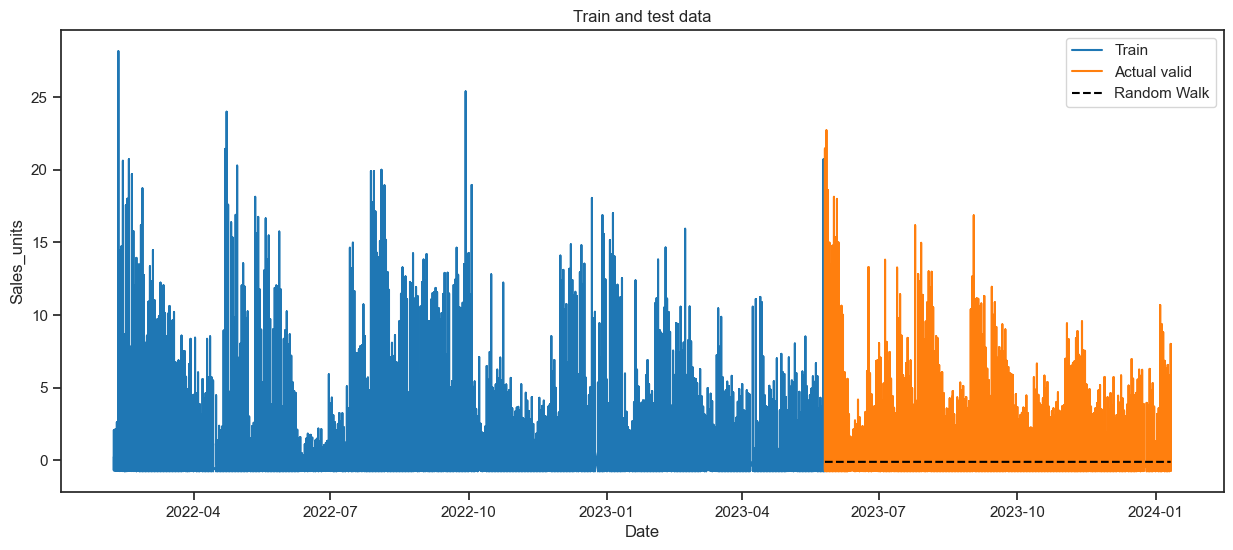

In [81]:
plt.figure(figsize = (15,6))

plt.plot(train_promo, label = "Train")
plt.plot(test_promo, label = "Actual valid" )
plt.plot(randomwalk, "--", color = "black", label = "Random Walk")

plt.xlabel("Date")
plt.ylabel("Sales_units")
plt.title("Train and test data")

plt.legend()

plt.show()

In [82]:
# Standarised rmse
print("MSE (Random Walk) : {:.4f}".format(MSE(test_promo['sales_units'],randomwalk)))
print("RMSE (Random Walk) : {:.4f}".format(RMSE(test_promo['sales_units'],randomwalk)))

MSE (Random Walk) : 0.8133
RMSE (Random Walk) : 0.9018


Un-standarise model data and get RMSE

In [83]:
test_promo.shape

(119646, 1)

In [84]:
inversed_test_promo = scaler.inverse_transform(test_promo[['sales_units']])

In [85]:
inversed_randomwalk = scaler.inverse_transform(forecast)

In [86]:
print("MSE (Random Walk) : {:.4f}".format(MSE(inversed_test_promo,inversed_randomwalk)))
print("RMSE (Random Walk) : {:.4f}".format(RMSE(inversed_test_promo,inversed_randomwalk)))

MSE (Random Walk) : 2432.1349
RMSE (Random Walk) : 49.3167


#### 4.4 Seasonal Naive Forecasting

In [87]:
M = 7

Seasonal_Naive = pd.Series(np.zeros(T_test_promo))
Seasonal_Naive.index = test_promo.index

for i in np.arange(T_test_promo):
    Seasonal_Naive[i] = promo_sales_units[T_train_promo + i - M]

forecast["Seasonal Naive"] = Seasonal_Naive

forecast

,sales_units,Benchmark Model,Seasonal Naive
calendar_day,,,
2023-05-26,-0.620079,-0.102853,-0.503703
2023-05-26,-0.322674,-0.102853,-0.697663
2023-05-26,-0.283882,-0.102853,-0.348535
2023-05-26,-0.594218,-0.102853,-0.283882
2023-05-26,-0.012338,-0.102853,-0.335605
...,...,...,...
2024-01-11,4.215988,-0.102853,-0.684733
2024-01-11,1.616925,-0.102853,-0.490773
2024-01-11,0.116968,-0.102853,-0.581287


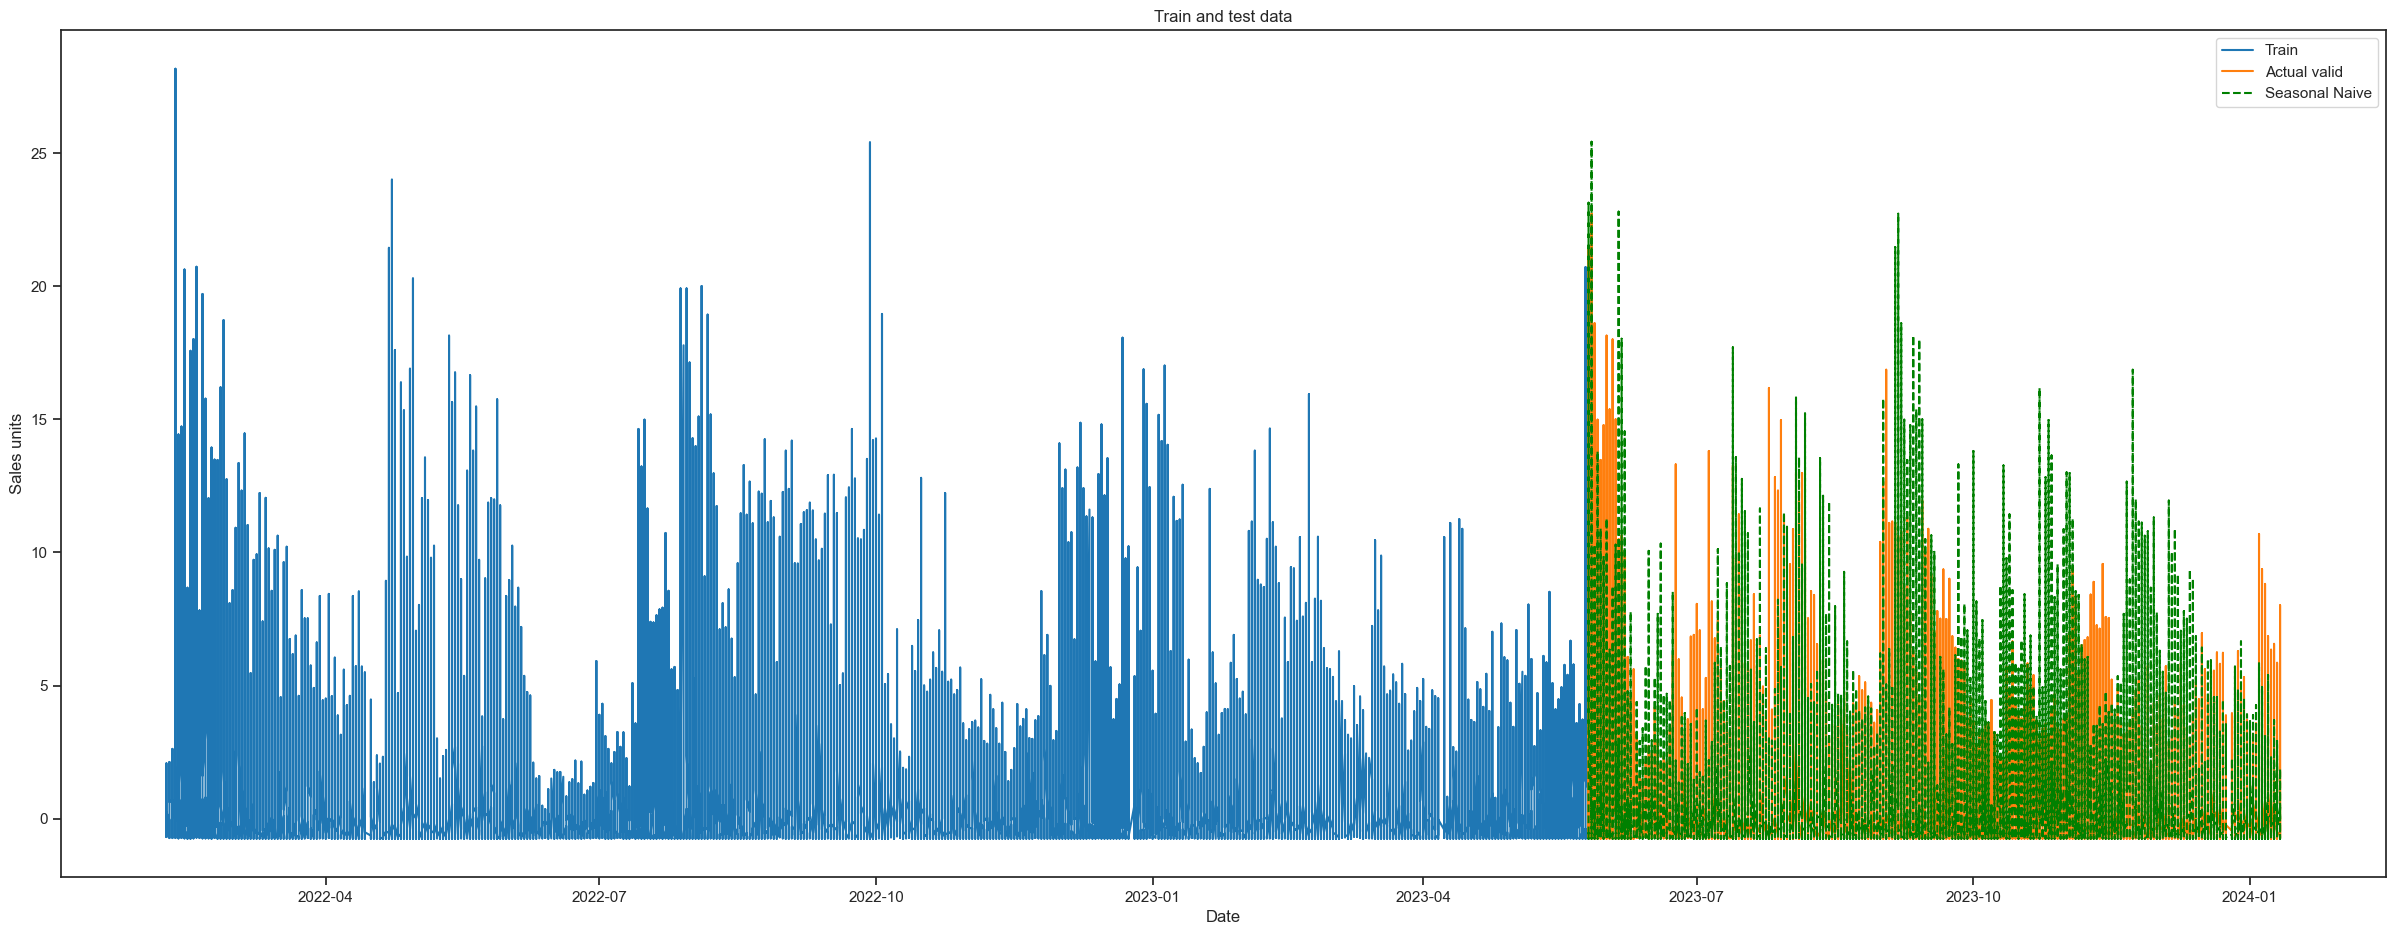

In [88]:
plt.figure(figsize = (30,11))

plt.plot(train_promo, label = "Train")
plt.plot(test_promo, label = "Actual valid")
plt.plot(Seasonal_Naive, "--", color = "green", label = "Seasonal Naive")

plt.title("Train and test data")
plt.xlabel("Date")
plt.ylabel("Sales units")
plt.legend()

plt.show()

In [89]:
# standarise rmse
print("MSE (Seasonal naive) : {:.4f}".format(MSE(test_promo['sales_units'],Seasonal_Naive)))
print("RMSE (Seasonal naive) : {:.4f}".format(RMSE(test_promo['sales_units'],Seasonal_Naive)))

MSE (Seasonal naive) : 1.7378
RMSE (Seasonal naive) : 1.3183


In [90]:
# Un-standarise 
inversed_seasonal = scaler.inverse_transform(forecast)

In [91]:
print("MSE (Seasonal naive) : {:.4f}".format(MSE(inversed_test_promo,inversed_seasonal)))
print("RMSE (Seasonal naive) : {:.4f}".format(RMSE(inversed_test_promo,inversed_seasonal)))

MSE (Seasonal naive) : 5085.9644
RMSE (Seasonal naive) : 71.3159


### 4.5 Simple Exponential Smoothing (SES)

In [92]:
# ses model
test_sales = test_promo['sales_units'] 

ses_model = SimpleExpSmoothing(test_sales)
fitted_model = ses_model.fit()

fitted_values = pd.Series(fitted_model.fittedvalues, index=test_sales.index)

fitted_model.summary()

Dep. Variable:,sales_units,No. Observations:,119646
Model:,SimpleExpSmoothing,SSE,82120.687
Optimized:,True,AIC,-45024.463
Trend:,None,BIC,-45005.079
Seasonal:,None,AICC,-45024.463
Seasonal Periods:,None,Date:,"Mon, 13 May 2024"
Box-Cox:,False,Time:,21:50:07
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1413266,alpha,True
initial_level,-0.6200793,l.0,False


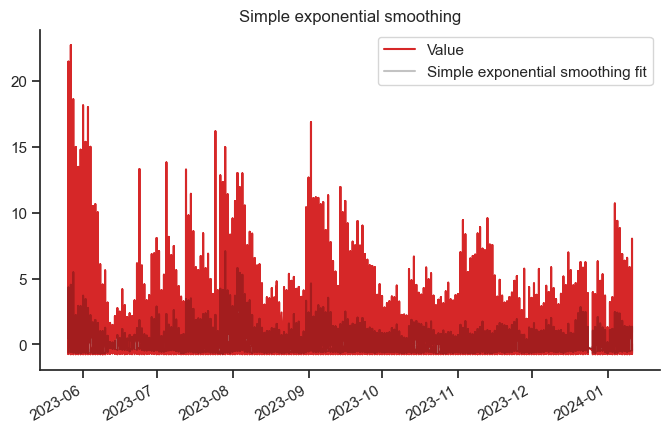

In [93]:
# prediction plot
fig, ax= plt.subplots(figsize=(8,5))
test_sales.plot(color=red, label='Value')
fitted_values.plot(color='black', label='Simple exponential smoothing fit', alpha=0.237)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Simple exponential smoothing')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

In [94]:
# standarise rmse
print("MSE (SES) : {:.4f}".format(MSE(test_promo['sales_units'],fitted_values)))
print("RMSE (SES) : {:.4f}".format(RMSE(test_promo['sales_units'],fitted_values)))

MSE (SES) : 0.6864
RMSE (SES) : 0.8285


In [95]:
# Un-standarise 
fitted_values = pd.DataFrame(fitted_model.fittedvalues, index=test_sales.index)

# de-standarized fitted value
inversed_ses = scaler.inverse_transform(fitted_values)

# convert de-standarized result into series for visualisation
inversed_ses = pd.Series(inversed_ses.flatten(), index=test_sales.index)

In [96]:
print("MSE (SES) : {:.4f}".format(MSE(test_promo['sales_units'],inversed_ses)))
print("RMSE (SES) : {:.4f}".format(RMSE(test_promo['sales_units'],inversed_ses)))

MSE (SES) : 4480.9527
RMSE (SES) : 66.9399


#### 4.6 Moving Average Model

#### 4.6.1 MA7

- MA7 is the average of 7 observations and divided by 7

In [97]:
# MA model and prediction
ma7_prediction = train_promo.rolling(7).mean()

MA7 = pd.Series(np.zeros(T_test_promo))

MA7.index = test_promo.index

for i in np.arange(T_test_promo):
    MA7[i] = promo_sales_units[T_train_promo - 1]

forecast["Moving Average Model"] = MA7
forecast

,sales_units,Benchmark Model,Seasonal Naive,Moving Average Model
calendar_day,,,,
2023-05-26,-0.620079,-0.102853,-0.503703,-0.102853
2023-05-26,-0.322674,-0.102853,-0.697663,-0.102853
2023-05-26,-0.283882,-0.102853,-0.348535,-0.102853
2023-05-26,-0.594218,-0.102853,-0.283882,-0.102853
2023-05-26,-0.012338,-0.102853,-0.335605,-0.102853
...,...,...,...,...
2024-01-11,4.215988,-0.102853,-0.684733,-0.102853
2024-01-11,1.616925,-0.102853,-0.490773,-0.102853
2024-01-11,0.116968,-0.102853,-0.581287,-0.102853


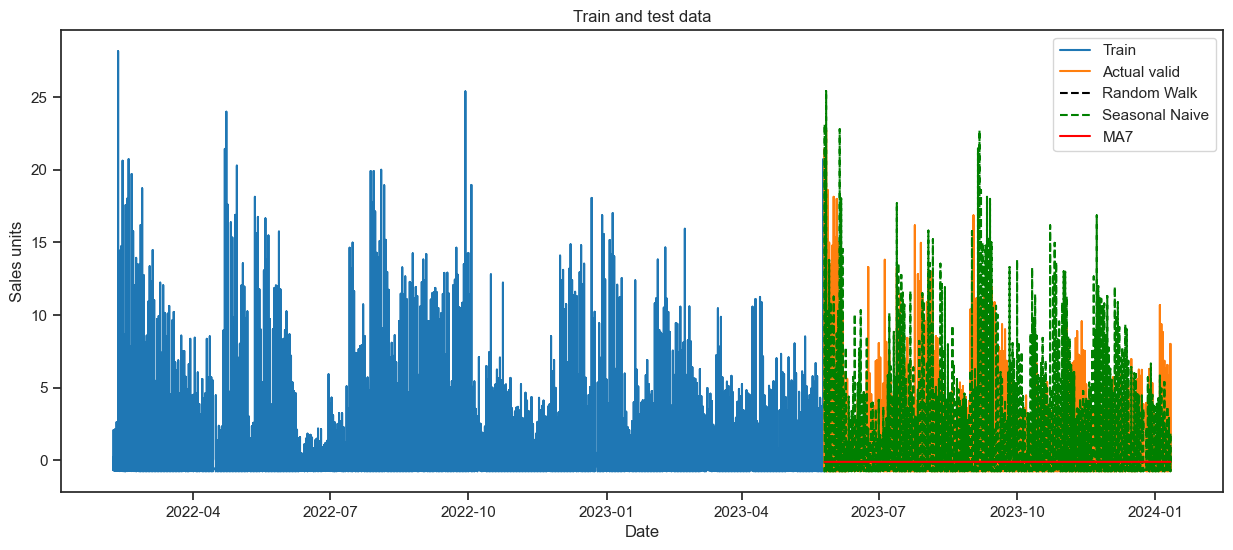

In [98]:
# line plot
plt.figure(figsize = (15,6))

plt.plot(train_promo, label = "Train")

plt.plot(test_promo, label = "Actual valid")

plt.plot(randomwalk, "--", color = "black", label = "Random Walk")

plt.plot(Seasonal_Naive, "--", color = "green", label = "Seasonal Naive")
plt.plot(MA7, "-", color = "red", label = "MA7")

plt.title("Train and test data")
plt.xlabel("Date")
plt.ylabel("Sales units")
plt.legend()

plt.show()

In [99]:
#standarised rmse
print("MSE (MA) : {:.4f}".format(MSE(test_promo['sales_units'],MA7)))
print("RMSE (MA) : {:.4f}".format(RMSE(test_promo['sales_units'],MA7)))

MSE (MA) : 0.8133
RMSE (MA) : 0.9018


In [100]:
# Un-standarise 
inversed_MA = scaler.inverse_transform(forecast)

In [101]:
print("MSE (MA) : {:.4f}".format(MSE(inversed_test_promo,inversed_MA)))
print("RMSE (MA) : {:.4f}".format(RMSE(inversed_test_promo,inversed_MA)))

MSE (MA) : 5030.5407
RMSE (MA) : 70.9263


#### 4.6.2 MA14
- MA14 is the average of 14 observations and divided by 14.

In [102]:
ma14_prediction = train_promo.rolling(14).mean()

MA14 = pd.Series(np.zeros(T_test_promo))

MA14.index = test_promo.index

for i in np.arange(T_test_promo):
    MA14[i] = promo_sales_units[T_train_promo - 1]

forecast["Moving Average Model"] = MA14
forecast

,sales_units,Benchmark Model,Seasonal Naive,Moving Average Model
calendar_day,,,,
2023-05-26,-0.620079,-0.102853,-0.503703,-0.102853
2023-05-26,-0.322674,-0.102853,-0.697663,-0.102853
2023-05-26,-0.283882,-0.102853,-0.348535,-0.102853
2023-05-26,-0.594218,-0.102853,-0.283882,-0.102853
2023-05-26,-0.012338,-0.102853,-0.335605,-0.102853
...,...,...,...,...
2024-01-11,4.215988,-0.102853,-0.684733,-0.102853
2024-01-11,1.616925,-0.102853,-0.490773,-0.102853
2024-01-11,0.116968,-0.102853,-0.581287,-0.102853


In [103]:
#standarised rmse
print("MSE (MA) : {:.4f}".format(MSE(test_promo['sales_units'],MA14)))
print("RMSE (MA) : {:.4f}".format(RMSE(test_promo['sales_units'],MA14)))

MSE (MA) : 0.8133
RMSE (MA) : 0.9018


In [104]:
inversed_MA = scaler.inverse_transform(forecast)

In [105]:
#unstandarised rmse
print("MSE (MA) : {:.4f}".format(MSE(inversed_test_promo,inversed_MA)))
print("RMSE (MA) : {:.4f}".format(RMSE(inversed_test_promo,inversed_MA)))

MSE (MA) : 5030.5407
RMSE (MA) : 70.9263


In [106]:
ma21_prediction = train_promo.rolling(21).mean()

MA21 = pd.Series(np.zeros(T_test_promo))

MA21.index = test_promo.index

for i in np.arange(T_test_promo):
    MA21[i] = promo_sales_units[T_train_promo - 1]

forecast["Moving Average Model"] = MA21
forecast

,sales_units,Benchmark Model,Seasonal Naive,Moving Average Model
calendar_day,,,,
2023-05-26,-0.620079,-0.102853,-0.503703,-0.102853
2023-05-26,-0.322674,-0.102853,-0.697663,-0.102853
2023-05-26,-0.283882,-0.102853,-0.348535,-0.102853
2023-05-26,-0.594218,-0.102853,-0.283882,-0.102853
2023-05-26,-0.012338,-0.102853,-0.335605,-0.102853
...,...,...,...,...
2024-01-11,4.215988,-0.102853,-0.684733,-0.102853
2024-01-11,1.616925,-0.102853,-0.490773,-0.102853
2024-01-11,0.116968,-0.102853,-0.581287,-0.102853


In [107]:
# Un-standarise 
inversed_MA = scaler.inverse_transform(forecast)

In [108]:
print("MSE (MA) : {:.4f}".format(MSE(inversed_test_promo,inversed_MA)))
print("RMSE (MA) : {:.4f}".format(RMSE(inversed_test_promo,inversed_MA)))

MSE (MA) : 5030.5407
RMSE (MA) : 70.9263


#### 4.7 ARIMA

First Difference:

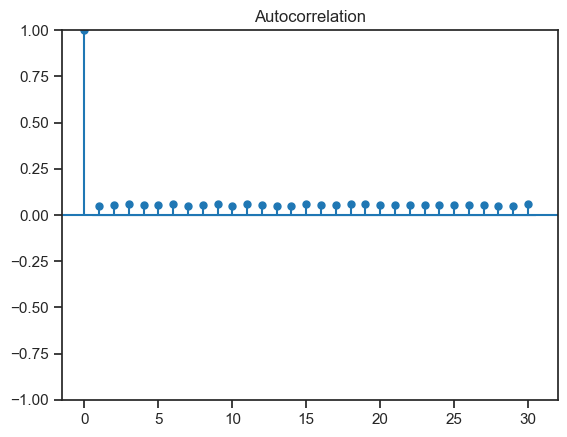

In [109]:
smt.graphics.tsa.plot_acf(train_promo, lags=30, alpha = 0.05)
plt.show()

In [110]:
s_diff = pd.Series.diff(train_promo).dropna()
s_diff

,0
calendar_day,
2022-02-07,0.297405
2022-02-07,-0.232752
2022-02-07,0.879285
2022-02-07,1.564610
2022-02-07,-2.379242
...,...
2023-05-26,0.349128
2023-05-26,0.064653
2023-05-26,-0.051723


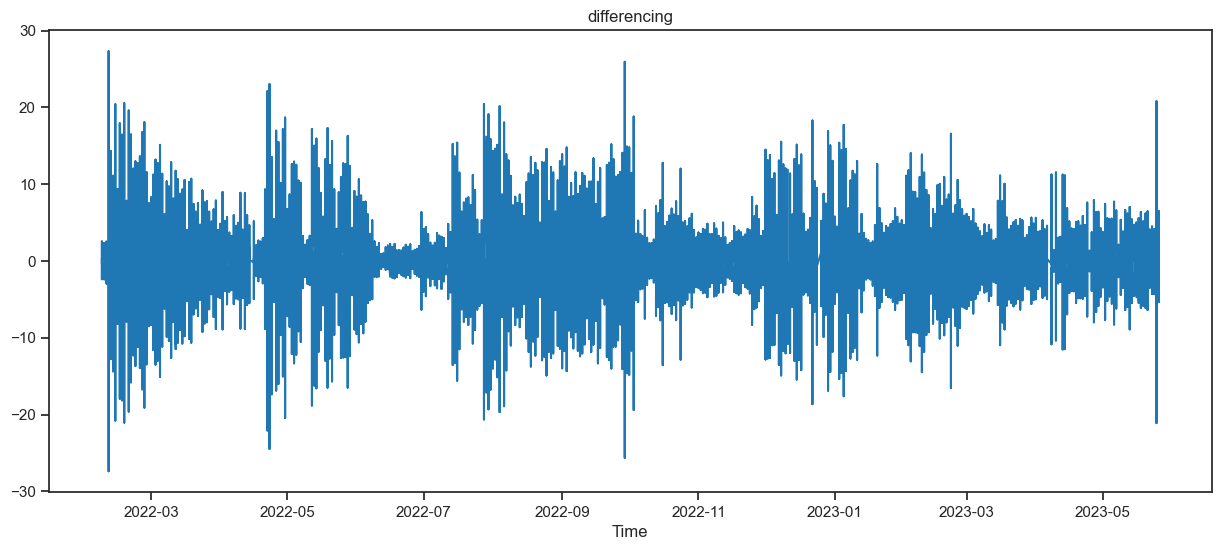

In [111]:
plt.figure(figsize=(15,6))
plt.plot(s_diff)
plt.xlabel("Time")
plt.title("differencing")
plt.show()

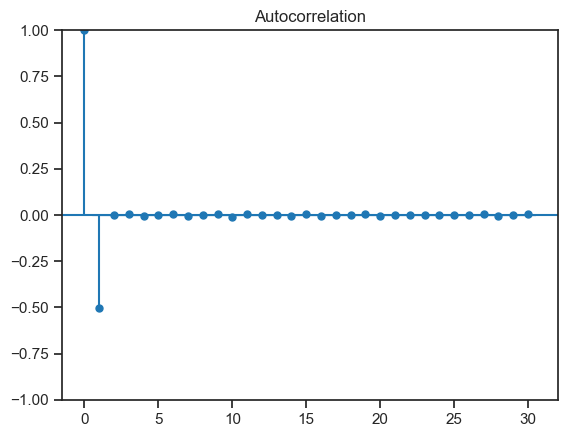

In [112]:
smt.graphics.tsa.plot_acf(s_diff, lags=30, alpha = 0.05)
plt.show()

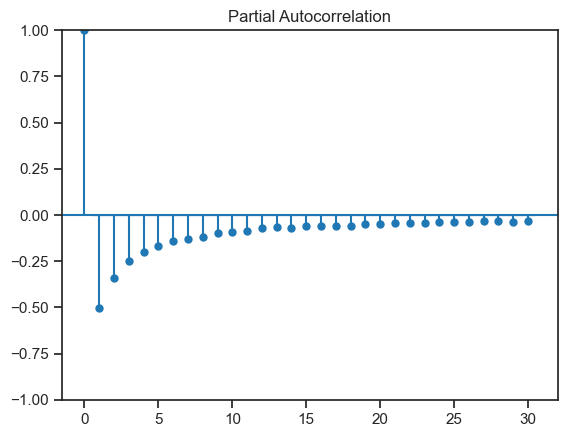

In [113]:
smt.graphics.tsa.plot_pacf(s_diff, lags=30, alpha = 0.05)
plt.show()

In [114]:
ARIMA1 = train_promo
model_arima = ARIMA(ARIMA1, order = (3,1,2)).fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:            sales_units   No. Observations:               185557
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -258917.582
Date:                Mon, 13 May 2024   AIC                         517847.164
Time:                        21:51:02   BIC                         517907.950
Sample:                             0   HQIC                        517865.113
                             - 185557                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9079      0.102     -8.887      0.000      -1.108      -0.708
ar.L2         -0.0048      0.003     -1.759      0.079      -0.010       0.001
ar.L3          0.0024      0.002      1.194      0.2

In [115]:
forecast_arima = pd.DataFrame(model_arima.forecast(119646))
forecast_arima.set_index(test_promo.index, inplace = True)
forecast_arima

,predicted_mean
calendar_day,
2023-05-26,-0.200594
2023-05-26,-0.199959
2023-05-26,-0.198498
2023-05-26,-0.200064
2023-05-26,-0.198648
...,...
2024-01-11,-0.199319
2024-01-11,-0.199319
2024-01-11,-0.199319


In [116]:
forecast = pd.DataFrame(test_promo.copy())
forecast["ARIMA"] = forecast_arima
forecast

,sales_units,ARIMA
calendar_day,,
2023-05-26,-0.620079,-0.200594
2023-05-26,-0.322674,-0.199959
2023-05-26,-0.283882,-0.198498
2023-05-26,-0.594218,-0.200064
2023-05-26,-0.012338,-0.198648
...,...,...
2024-01-11,4.215988,-0.199319
2024-01-11,1.616925,-0.199319
2024-01-11,0.116968,-0.199319


In [117]:
# Un-standarise 
inversed_arima = scaler.inverse_transform(forecast)

In [118]:
print("MSE (ARIMA) : {:.4f}".format(MSE(inversed_test_promo,inversed_arima)))
print("RMSE (ARIMA) : {:.4f}".format(RMSE(inversed_test_promo,inversed_arima)))

MSE (ARIMA) : 2501.1664
RMSE (ARIMA) : 50.0117


### 4.8 Summary Table (Promo sales units)

| Model | Test set RMSE (Un-standarised) | Test set RMSE (Standarised)
|-----|-----|----|
| Random Walk | 49.3167|0.9018|
| Seasonal Random Walk | 71.3159 |1.3183|
|Simple exponential smoothing| 66.9399|0.8285|
| Moving Average (7) Model | 70.9263 |0.9018|
|Moving Average (14) Model | 57.3495|0.9018|